# GWANW22 Student Workshop

## LIGO Tutorial #3: Heirarchical inference with GWPopulation
Notebook originally authored by Jacob Golomb [here](https://github.com/gw-odw/odw-2022/blob/main/Tutorials/Advanced_topics/Tuto_A.2_Population_Inference_with_GWPopulation.ipynb), adapted by Bruce Edelman.
## Installations

If running on google colab un-comment the next cell to install required packages

In [6]:
#!pip install gwpopulation==0.6.3
#!pip install nestle==0.2.0

## Background / Theory

See Slides Presented before this [here]()

## Imports

In [7]:
import gwpopulation
import numpy as np
import bilby
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import glob
from copy import deepcopy

## Data downloads

Let's download the necessary data for a simplified population analysis. The firt command will download the posterior samples from O3b (downsampled so we can run a fast analysis).

Next we also download the file that stores the info from the software injection campaign that will allow us to estimate the selection effects

In [8]:
#!wget -O downsampled.tar.gz "https://dcc.ligo.org/public/0182/T2200137/001/O3bPE_downsampled.tar.gz"
#!tar -xvzf downsampled.tar.gz
#!wget -O injections.h5 "https://zenodo.org/record/5546676/files/endo3_bbhpop-LIGO-T2100113-v12.hdf5"

In [9]:
posterior_sample_files = glob.glob('S*.h5')
posterior_sample_files

['S191129u.h5',
 'S200202ac.h5',
 'S200209ab.h5',
 'S200311bg.h5',
 'S191222n.h5',
 'S200224ca.h5',
 'S191105e.h5',
 'S200208q.h5',
 'S191103a.h5',
 'S200128d.h5',
 'S200129m.h5',
 'S200105ae.h5',
 'S200115j.h5',
 'S191216ap.h5',
 'S200316bj.h5',
 'S200225q.h5',
 'S191215w.h5',
 'S191204r.h5',
 'S200112r.h5',
 'S200302c.h5',
 'S200219ac.h5',
 'S191109d.h5',
 'S191230an.h5',
 'S200216br.h5',
 'S191127p.h5']

Load in the BBH posterior sample files and save the m1/q samples 

In [10]:
posteriors = []
for file in posterior_sample_files:
    if '200105' in file or '200115' in file: # ignore the two NSBH events that we grabbed
        continue
    with h5py.File(file, 'r') as eventfile:
        post = pd.DataFrame()
        samples = eventfile['C01:Mixed']['posterior_samples']
        post['mass_ratio'] = samples['mass_ratio']
        post['mass_1'] = samples['mass_1_source']
        posteriors.append(post)

Now we load in the injection file and return a dictionary of the parameters and relevant information for all injections that were found by the search pipelines. This is all injections that had an IFAR > 1 in one of the search pipelines. 

In [11]:
def load_found_injections(fi='injections.h5', ifar_thresh=1):
    with h5py.File(fi, 'r') as f:
        data = f['injections']
        found = np.zeros_like(data["mass1_source"][()], dtype=bool)
        for key in data:
            if "ifar" in key.lower():
                found = found | (data[key][()] > ifar_thresh)
        injs = dict(
            mass_1=np.asarray(data["mass1_source"][found]),
            mass_ratio=np.asarray(data["mass2_source"][found] / data["mass1_source"][found]),
            total_generated=int(data.attrs["total_generated"][()]),
            analysis_time=data.attrs["analysis_time_s"][()] / 365.25 / 24 / 60 / 60,
            prior=np.asarray(data['mass1_source_mass2_source_sampling_pdf'][found])*np.asarray(data["mass1_source"][found])
        )
    return injs        

We are going to fit the Truncated powerlaw model in primary mass and mass ratio. This model has 4 parameters: $\alpha, \beta, m_\mathrm{min}$ and $m_\mathrm{max}$ and is defined by:

$$
p(m_1, q | \alpha, \beta, m_\mathrm{min}, m_\mathrm{max}) \propto m_1^{-\alpha} q^{\beta}
$$

for all primary and secondary masses above $m_\mathrm{min}$ and below $m_\mathrm{max}$

In [12]:
popmodel_m1_q = gwpopulation.models.mass.power_law_primary_mass_ratio

Load in the found injections and setup the VTCalculator that does the importance resampling over the injections to calculate our selection effects term in the likelihood

In [13]:
injdata = load_found_injections('injections.h5')
VTCalculator = gwpopulation.vt.ResamplingVT(deepcopy(popmodel_m1_q), injdata, n_events=len(posteriors))

Setup the likelihood function and our prior dicts with agnostic uniform priors on our 4 hyper-parameters we want to fit

In [14]:
likelihood = gwpopulation.hyperpe.HyperparameterLikelihood(posteriors=posteriors, 
                                                           hyper_prior=popmodel_m1_q, 
                                                           selection_function=VTCalculator)

priors = bilby.core.prior.PriorDict(
    dict(
    alpha = bilby.core.prior.Uniform(minimum=0, maximum=4, latex_label='$\\alpha$'),
    beta = bilby.core.prior.Uniform(minimum=0, maximum=7, name='beta', latex_label='$\\beta_{q}$'),
    mmax = bilby.core.prior.Uniform(minimum=30, maximum=60, name='mmax', latex_label='$m_{\\max}$'),
    mmin = bilby.core.prior.Uniform(minimum=3, maximum=12, name='mmin', latex_label='$m_{\\min}$'),
))

18:38 bilby WARNING : Cannot import cupy, falling back to numpy.
18:38 bilby INFO    : No prior values provided, defaulting to 1.


Now we run the sampler!! This should take ~5min to run

In [15]:
result = bilby.run_sampler(likelihood=likelihood, priors=priors, 
                  label='O3b_tutorial', use_ratio=True, 
                  resume=False, outdir='./O3b_result', sampler='nestle')

18:38 bilby INFO    : Running for label 'O3b_tutorial', output will be saved to './O3b_result'
18:38 bilby INFO    : Search parameters:
18:38 bilby INFO    :   alpha = Uniform(minimum=0, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
18:38 bilby INFO    :   beta = Uniform(minimum=0, maximum=7, name='beta', latex_label='$\\beta_{q}$', unit=None, boundary=None)
18:38 bilby INFO    :   mmax = Uniform(minimum=30, maximum=60, name='mmax', latex_label='$m_{\\max}$', unit=None, boundary=None)
18:38 bilby INFO    :   mmin = Uniform(minimum=3, maximum=12, name='mmin', latex_label='$m_{\\min}$', unit=None, boundary=None)
/home/bedelman/anaconda3/envs/gwpop_cpu/lib/python3.9/site-packages/gwpopulation/hyperpe.py:124: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.samples_per_posterior) + xp.log(
18:38 bilby INFO    : Single likelihood evaluation took 2.645e-02 s
18:38 bilby WARNING : Supplied argument 'npool' not an argument of 'Nestle', removing

it=   427 logz=-1000000000000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000

/home/bedelman/anaconda3/envs/gwpop_cpu/lib/python3.9/site-packages/gwpopulation/utils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  norm = (1 + alpha) / (high ** (1 + alpha) - low ** (1 + alpha))
/home/bedelman/anaconda3/envs/gwpop_cpu/lib/python3.9/site-packages/gwpopulation/utils.py:79: RuntimeWarning: invalid value encountered in multiply
  prob *= (xx <= high) & (xx >= low)


it=  3090 logz=25.45528900000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


18:42 bilby INFO    : Sampling time: 0:03:38.897291
18:42 bilby INFO    : Summary of results:
nsamples: 3591
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.087
ln_bayes_factor: 25.781 +/-  0.087



Let's look at the corner plot of the posterior distribution

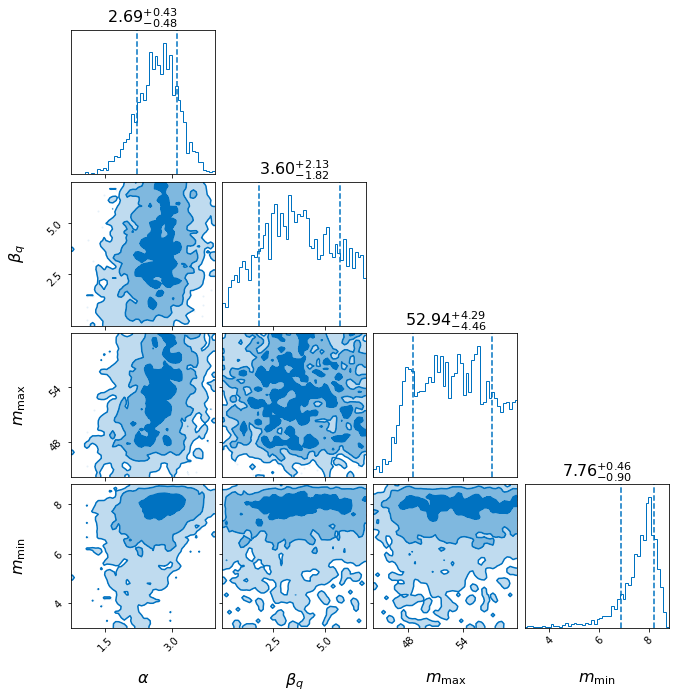

In [16]:
result.plot_corner(save=False);

And finally let's plot the m1 and q distribtions that this posterior distribution implies

In [17]:
m1s = np.linspace(2,70, 1000)
qs = np.linspace(0,1,1000)
mm, qq = np.meshgrid(m1s, qs)

mlines = []
qlines = []
samples = result.posterior.sample(1000)
for ii in range(len(samples)):
  sample = samples.iloc[ii]
  m1probs = gwpopulation.utils.powerlaw(m1s, alpha = -sample['alpha'], high=sample['mmax'], low=sample['mmin'])
  qprobs = gwpopulation.cupy_utils.trapz(gwpopulation.utils.powerlaw(qq, alpha=sample['beta'], high=1, low=sample['mmin'] / mm), m1s)
  mlines.append(m1probs)
  qlines.append(qprobs)
mlines = np.array(mlines)
qlines = np.array(qlines)

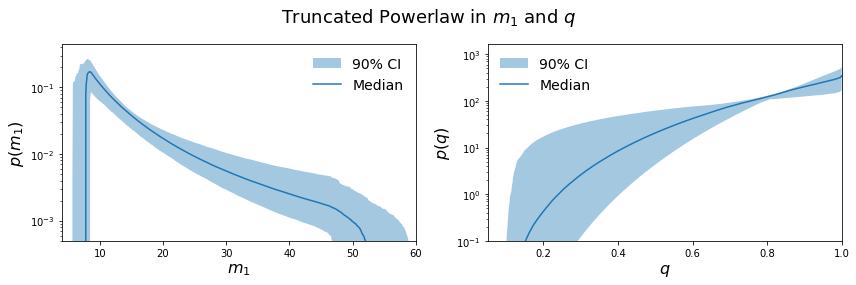

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axs[0].fill_between(m1s, np.percentile(mlines, 5, axis=0), np.percentile(mlines, 95, axis=0), alpha = 0.4, label='90% CI')
axs[0].plot(m1s, np.percentile(mlines, 50, axis=0), label='Median')
axs[0].set_xlim(4,60)
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$p(m_1)$', fontsize=16)
axs[0].set_xlabel(r'$m_1$', fontsize=16)
axs[1].fill_between(qs, np.percentile(qlines, 5, axis=0), np.percentile(qlines, 95, axis=0), alpha = 0.4, label='90% CI')
axs[1].plot(qs, np.percentile(qlines, 50, axis=0),label='Median')
axs[1].set_xlim(0.05,1)
axs[1].legend(frameon=False, fontsize=14)
axs[0].legend(frameon=False, fontsize=14)
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$p(q)$', fontsize=16)
axs[1].set_xlabel(r'$q$', fontsize=16)
axs[0].set_ylim(5e-4)
axs[1].set_ylim(1e-1)
plt.suptitle(r'Truncated Powerlaw in $m_1$ and $q$', fontsize=18)
plt.tight_layout()

## Extra Challenges for More Realistic Population Analyses

This tutorial was intended to demonstrate the basics of population inference and how to use GWPopulation to infer population properties from GW observations. Several aspects of using population inference with GW events were left out or simplified for this tutorial. These aspects include:

* A complete population model: The population models we use in LVK population analyses typically characterize mass, spin, and redshift distributions. Some of the hyperparameters of these distribution exhibit nontrivial correlations, so it is important to do to include them all in the population model. Furthermore, we know now that a simple truncated power law is insufficient to provide the best fit to the mass distribution; we therefore use more complicated mass distributions that allow for more features such as peaks and power law breaks. Additionally, the mass distributions we use typically include a "smooth turn-on" at low masses so the mass distribution does not begin right at the peak of the power law.

* Jacobians: If the events are not sampled in terms of the same exact physical parameters characterized by the population model, a jacobian is necessary to transform the probability distribution correctly. For example, LVK parameter estimation imposes priors on the detector-frame masses, whereas our population model characterizes the source-frame primary mass and the mass ratio distributions. The conversion between these parameters must be taken into account to do population inference correctly.

* Single-event priors: While we reweighted samples from the posterior distribution into our population model, the equations above are expressed in terms of reweighting samples from the likelihood distribution. Therefore, if there are nontrivial priors imposed on the single-event posteriors, those must be divided out to convert the posterior samples to likelihood samples.

* Speed: When working with ~100 events each with ~10,000 posterior samples, computing the likelihoods for population inference can be slow. Fortunately, as the the likelihood involves mainly array broadcasting and matrix manipulations, this can usually be significantly sped up by computing on a GPU. GWPopulation can handle this by setting an argument cupy = True in the HyperparameterLikelihood class. You just need to make sure your population model and selection function are using cupy and GPU-friendly operations as well. A lot of times you can simply use cupy functions as drop-ins for numpy functions. We find that this can substantially reduce the computation time for hierarchical inference problems.

Sampling: Typically you should play with the sampler settings and convergence criteria to be optimal for your particular problem. With dynesty we typically increase the nact argument to make sure the final output is better-converged. We also can increase the nlive argument to use more "live points" the sampler uses. There are various settings to change, and you can read more about sampling with Bilby's implementations in Bilby's docs and links therein.

A complete catalog: We might as well use all the data we can! Of course, we have access to data not just from O3b, but also O1, O2, and O3a. A complete catalog of sources (using, say, 70 events rather than ~30) will inform our population inference much more. We only used O3b events in this tutorial for simplicity.



## Challenge Questions

If we had included GW190814, an O3a event with $m_1 = 23M_\odot$ and $m_2 = 2.6M_\odot$, how would the inferred value of
change? If in O4 we detect relatively more than expected low-mass black holes, how would this affect the inferred value for?

## Further Reading

If you've made it this far, you may be interested in reading further details about implementations of population inference for GW studies. I recommend:

* LIGO, Virgo, KAGRA collaboration 2021: [Collaboration paper](https://arxiv.org/abs/2111.03634) analyzing the population of compact binary mergers in GWTC-3. See the methods section for details on the models and codes used in this work.

* [Thrane & Talbot 2018](https://arxiv.org/abs/1809.02293): Contains an overview of Bayesian inference as applied to GW analyses, as well as mathematical and conceptual background of population inference. Appendices contain many formulae that users may find useful.

* [GWPopulation_pipe](https://git.ligo.org/RatesAndPopulations/gwpopulation_pipe): This is the pipeline we use to actually run population analyses using GWPopulation. This pipeline conveniently wraps the various population models, sampling, and conversion routines and outputs for a full LVK population analysis run.

* If you are interesting in learning how to view and interpret the outputs of the GWPopulation analyses for the GWTC-3 Astrophysical Distributions paper, I encourage you to download the correpsonding data release from this Zenodo page and check out the "tutorials" subdirectory.

